# Cyber Data Analytics, CS4035
## Lab assignment 1: Fraud detection
### April 2019

### Importing data from CSV file

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

data = pd.read_csv('./data_for_student_case.csv', sep = ',')
orig_shape = data.shape
nas = data.isna()
nas_id = np.sum(nas, 1)

print("Amount of nan values in Chargeback: ", np.sum(data['simple_journal'][nas_id > 0] == 'Chargeback'), "\n")


print("NaN values per feature: \n", np.sum(nas, 0), "\n")

# data = data.dropna()

# print("Number of NaN values omitted: ", orig_shape[0] - data.shape[0])

# print(data.dtypes)

labels = data['simple_journal']
print("Number of non-fraud: ", np.sum(labels == 'Settled'), ", with ratio: ", np.sum(labels == 'Settled')/len(labels))
print("Number of fraud: ", np.sum(labels == 'Chargeback'), ", with ratio: ", np.sum(labels == 'Chargeback')/len(labels))
print("Number refused: ", np.sum(labels == 'Refused'), ", with ratio: ", np.sum(labels == 'Refused')/len(labels))

data.groupby(by = 'simple_journal').count()

Amount of nan values in Chargeback:  0 

NaN values per feature: 
 txid                                0
bookingdate                         0
issuercountrycode                 493
txvariantcode                       0
bin                               140
amount                              0
currencycode                        0
shoppercountrycode                482
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    14717
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64 

Number of non-fraud:  236691 , with ratio:  0.8151021757546956
Number of fraud:  345 , with ratio:  0.0011880901708783602
Number refused:  53346 , with ratio:  0.1837097340744261


,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
simple_journal,,,,,,,,,,,,,,,,
Chargeback,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345
Refused,53346,53346,52857,53346,53206,53346,53346,53206,53346,51823,53346,53346,53346,53346,53346,53346
Settled,236691,236691,236687,236691,236691,236691,236691,236349,236691,223497,236691,236691,236691,236691,236691,236691


## Convesion of categorical data to numeric

In [2]:
data_cat = data.copy(True)

data_oneHot = pd.get_dummies(data, columns = ['issuercountrycode', 'txvariantcode', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'accountcode'])

label_mapping = {}

# Convert currency code in order to 'amount' in a single code
label_mapping['currencycode'] = {'SEK': 0.09703, 'MXN': 0.04358, 'AUD': 0.63161, 'NZD': 0.58377, 'GBP':1.13355} 
data.replace({'currencycode' : label_mapping['currencycode']}, inplace=True)
data['amount'] = data['amount'] * data['currencycode']

label_mapping['simple_journal'] = {'Settled': 0, 'Refused' : 0, 'Chargeback' : 1}
data.replace({'simple_journal' : label_mapping['simple_journal']}, inplace=True)

# Convert all the rest columns which are of type 'object'
char_cols = data.dtypes.pipe(lambda x: x[x == 'object']).index

for c in char_cols:
    data[c], label_mapping[c] = pd.factorize(data[c])

label_mapping

{'currencycode': {'SEK': 0.09703,
  'MXN': 0.04358,
  'AUD': 0.63161,
  'NZD': 0.58377,
  'GBP': 1.13355},
 'simple_journal': {'Settled': 0, 'Refused': 0, 'Chargeback': 1},
 'bookingdate': Index(['2015-11-09 14:26:51', '2015-11-09 14:27:38', '2015-11-23 16:34:16',
        '2015-11-23 16:34:51', '2015-11-09 14:26:08', '2015-11-09 14:26:25',
        '2015-11-09 14:26:47', '2015-11-23 16:34:29', '2015-12-08 19:58:35',
        '2015-11-09 14:25:50',
        ...
        '2015-11-03 08:12:13', '2015-11-03 08:12:14', '2015-11-03 22:33:58',
        '2015-11-03 18:57:00', '2015-11-02 20:34:44', '2015-11-02 20:34:30',
        '2015-10-31 20:04:21', '2015-10-31 22:03:39', '2015-11-02 20:16:57',
        '2015-11-03 18:57:01'],
       dtype='object', length=92951),
 'issuercountrycode': Index(['MX', 'US', 'BR', 'CA', 'ES', 'CH', 'SA', 'TH', 'SG', 'NL',
        ...
        'CZ', 'KY', 'CG', 'CM', 'BJ', 'BF', 'CD', 'MV', 'CV', 'JM'],
       dtype='object', length=136),
 'txvariantcode': Index(['mccre

### HeatMap

KeyboardInterrupt: 

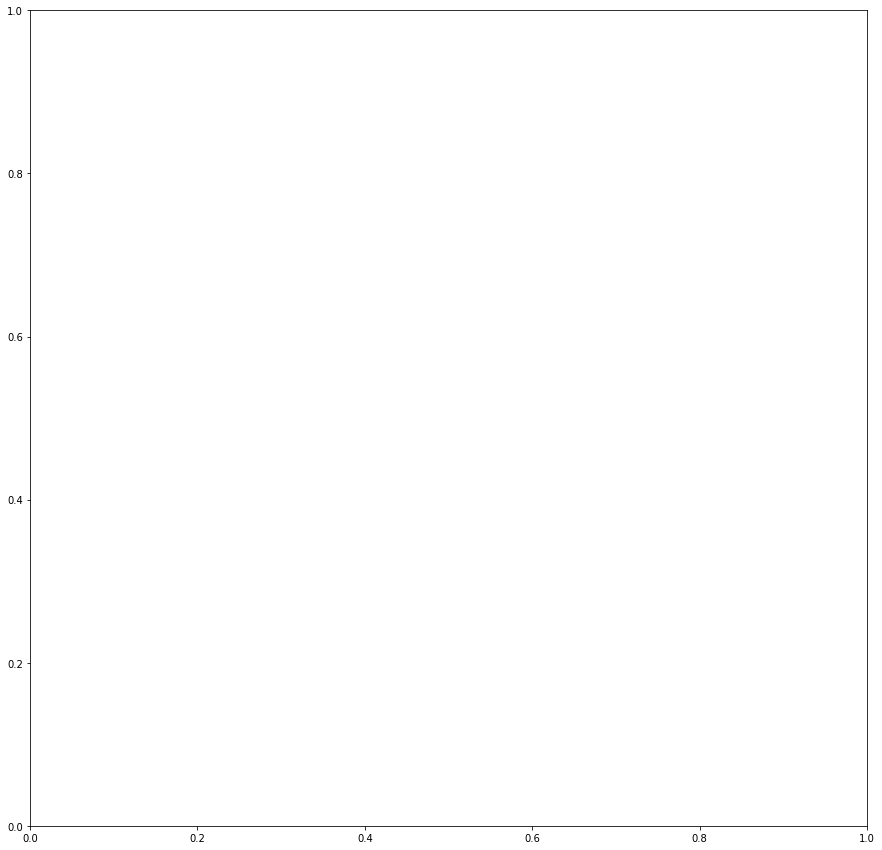

In [3]:
labels = ['txvariantcode', 'currencycode', 'shopperinteraction', 'simple_journal',  
          'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode']

plt.figure(figsize = (15,15))
plt.pcolor(data[labels])
plt.xticks(np.arange(len(labels)), labels, rotation = 60)
plt.colorbar()

### Aggregated values per card id

(223071, 6)


Text(0.5, 1.0, 'Fraud')

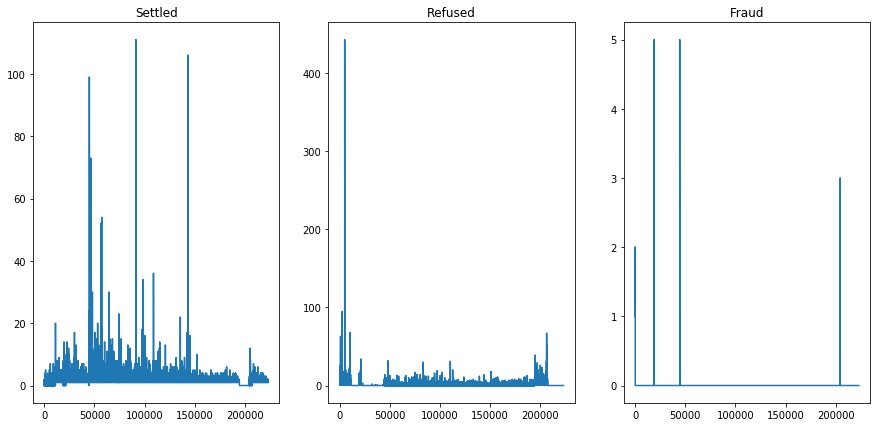

In [32]:
data_agg = data_cat[['card_id', 'simple_journal', 'amount']]

dd = pd.get_dummies(data_agg, columns = ['simple_journal'])

dd['sum_fraud'] = dd['amount'] * dd['simple_journal_Chargeback']
dd['sum_ref'] = dd['amount'] * dd['simple_journal_Refused']
dd['sum_OK'] = dd['amount'] * dd['simple_journal_Settled']

dd_user = dd.groupby(by = 'card_id', sort = False).agg({
    'simple_journal_Settled' : sum,
    'sum_OK' : 'mean',
    'simple_journal_Refused' : sum,
    'sum_ref' : 'mean',
    'simple_journal_Chargeback' : sum,
    'sum_fraud' : 'mean'
})

print(dd_user.values.shape)

# Visualizations
f, ax = plt.subplots(1, 3, figsize = (15,7))
ax[0].plot(dd_user.values[:, 0])
ax[0].set_title("Settled")
ax[1].plot(dd_user.values[:, 2])
ax[1].set_title("Refused")
ax[2].plot(dd_user.values[:, 4])
ax[2].set_title("Fraud")

In [43]:
test = data['bookingdate'].str.extract('(....-..-..)', expand=True)
test
tt = test[0].unique().sort()


None


### Visualizations

Text(0, 0.5, 'mean amount per group')

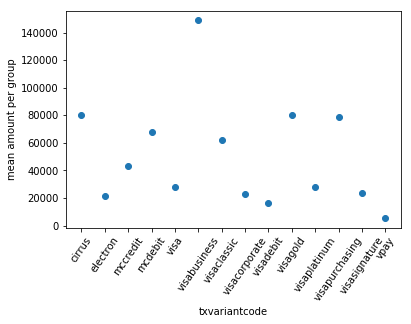

In [35]:
code = data_cat[['txvariantcode', 'amount']].groupby(['txvariantcode']).mean()
code.values
labels = code.index.values
plt.scatter(np.arange(len(code.values)), code.values)
plt.xticks(np.arange(len(code.values)), labels, rotation = '55')
plt.xlabel('txvariantcode')
plt.ylabel('mean amount per group')

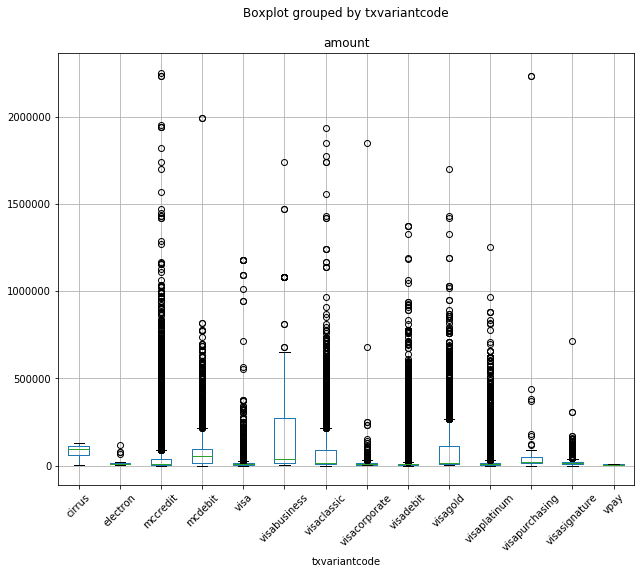

In [36]:
data_cat.boxplot(column = 'amount', by = 'txvariantcode', figsize = (10, 8), rot = '45')

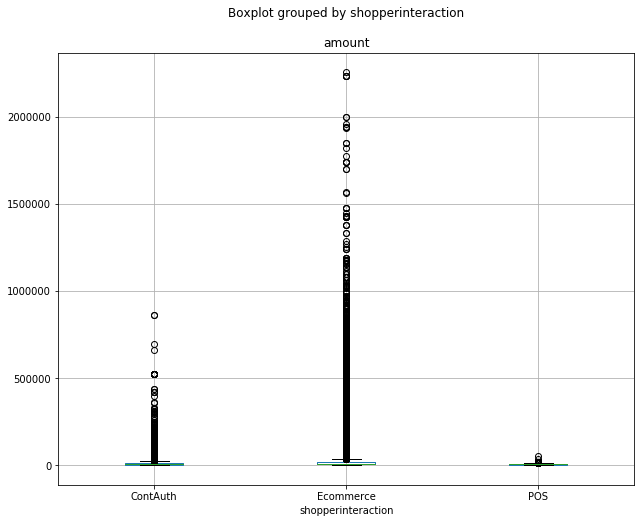

In [38]:
data_cat.boxplot(column = ['amount'], by = 'shopperinteraction', figsize = (10,8))

### Number of IP addresses per card id
#### The more addresses the more suspicious the transactions are

In [40]:
data_cat[['card_id', 'ip_id']].groupby('card_id').nunique().sort_values(by = 'ip_id', ascending = False).head()

,card_id,ip_id
card_id,,
card267365,1,25
card183189,1,25
card11998,1,23
card210128,1,22
card18592,1,20


## Classification

In [3]:
from PlotConfusionMatrix import *
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from RocAnalysis import *

X = data.drop(['simple_journal', 'creationdate', 'bookingdate', 'currencycode'], axis = 1).values
y = data['simple_journal'].values

# Imputing missing values.. we could alternatively just remove these samples
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
print(np.sum(np.isnan(X)))
X = imp.fit_transform(X)

imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
X = imp.fit_transform(X)

print("Fraud class samples: ", np.sum(y == 1))
print("Non-fraud class samples: ", np.sum(y == 0))
print("Ratio: ", np.sum(y == 1)/np.sum(y == 0))

# 10-Fold cross validation used for estimating performance
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

140
Fraud class samples:  345
Non-fraud class samples:  290037
Ratio:  0.001189503408185852


AUC:  0.8730846277905102  +-  0.049277165494376954
F1:  0.031106126922385673  +-  0.012413929146414732


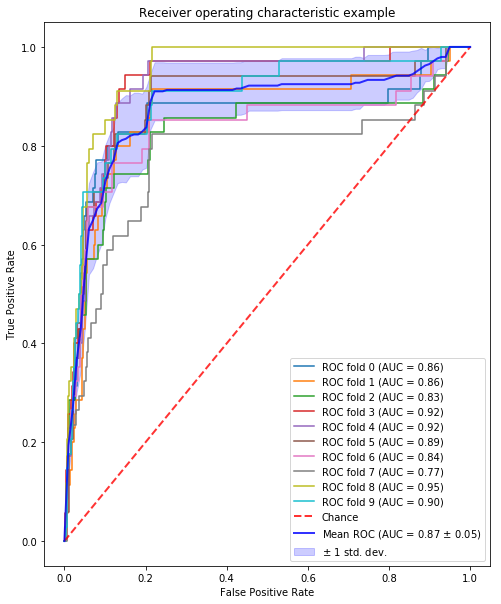

Confusion matrix, without normalization
[[287943   2094]
 [   306     39]]


<Figure size 432x288 with 0 Axes>

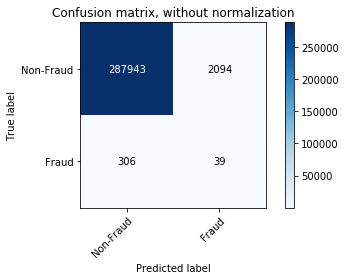

In [4]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

# Use cross-validation to determine the best overasmpling ratio
# ratios = np.arange(0.1, 1, 0.1)
ratios = np.arange(0.2, 1, 0.2)

for r in ratios: 
    sm = BorderlineSMOTE(sampling_strategy=r)
    roc_analysis(X, y, clf, cv, False, False, False, False, sm)

26157 2847 6 29
26225 2779 10 25
26197 2807 12 23
26132 2872 6 29
25942 3062 13 22
26019 2985 9 25
25827 3177 9 25
26197 2806 5 29
26186 2817 9 25
25857 3146 15 19


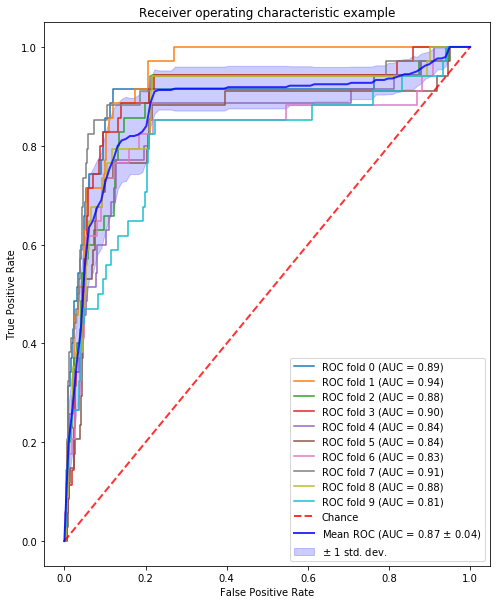

Confusion matrix, without normalization
[[260739  29298]
 [    94    251]]


<Figure size 432x288 with 0 Axes>

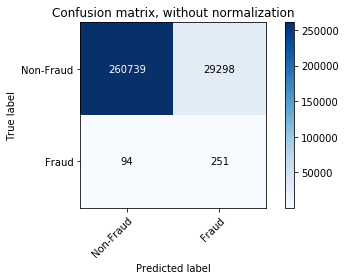

In [8]:
# Modifying class priors for GaussianNB
clf = GaussianNB(priors = [0.99, 0.01])
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

29004 0 35 0
29004 0 35 0


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


29004 0 35 0
29003 1 35 0
29004 0 35 0
29003 1 34 0
29003 1 34 0
29002 1 34 0
29003 0 34 0
29003 0 34 0


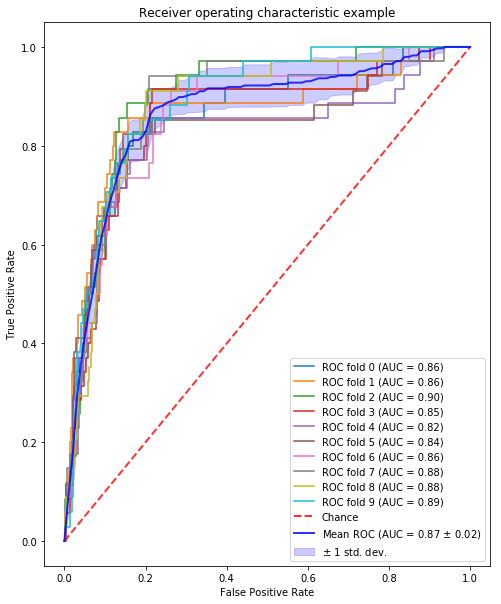

Confusion matrix, without normalization
[[290033      4]
 [   345      0]]


<Figure size 432x288 with 0 Axes>

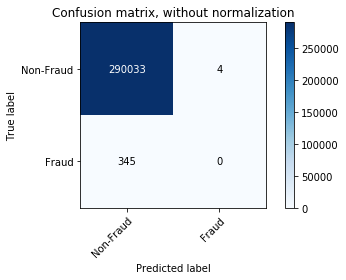

In [22]:
from  sklearn.linear_model import LogisticRegression as LR


clf = LR(C = 1, solver = 'lbfgs', multi_class = 'auto')
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

28654 350 29 6
28612 392 27 8
28606 398 27 8
28602 402 27 8
28618 386 27 8
28655 349 28 6
28672 332 24 10
28624 379 25 9
28608 395 31 3
28644 359 27 7


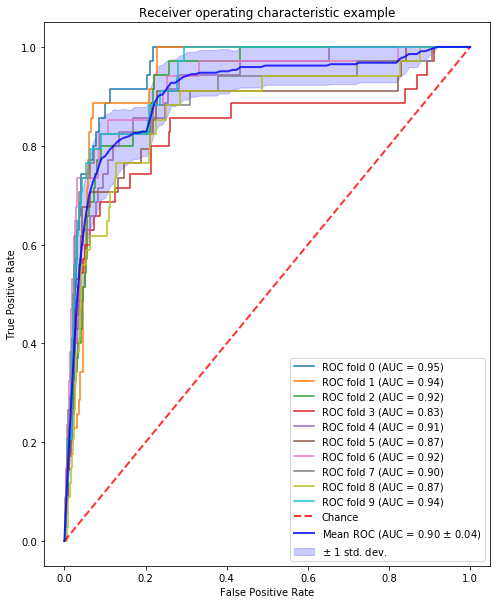

Confusion matrix, without normalization
[[286295   3742]
 [   272     73]]


<Figure size 432x288 with 0 Axes>

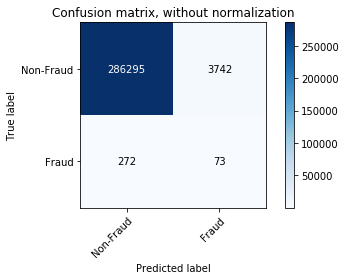

In [16]:
# assigning different class weights
clf = LR(C = 1, solver = 'lbfgs', multi_class = 'auto', class_weight={0:1, 1:100})
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


29004 0 0 35
29004 0 3 32
29004 0 1 34
29003 1 0 35
29004 0 1 34
29004 0 0 34
29004 0 0 34
29003 0 1 33
29003 0 1 33
29003 0 0 34


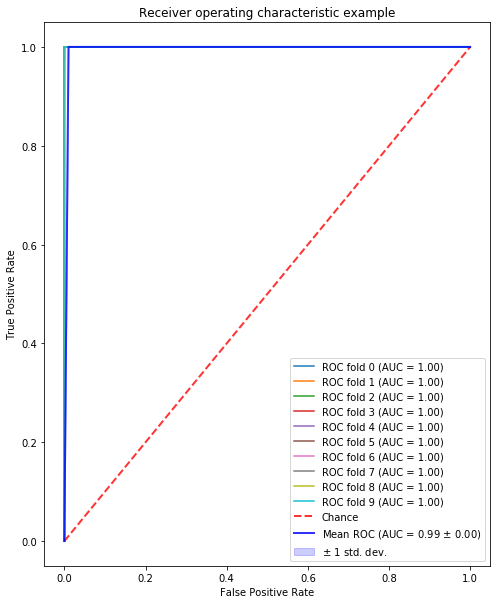

Confusion matrix, without normalization
[[290036      1]
 [     7    338]]


<Figure size 432x288 with 0 Axes>

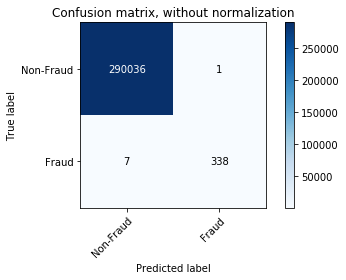

In [11]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

28980 24 35 0
28980 24 35 0
28974 30 35 0
28971 33 35 0
28973 31 35 0
28969 35 34 0
28970 34 34 0
28975 28 34 0
28969 34 34 0
28968 35 34 0


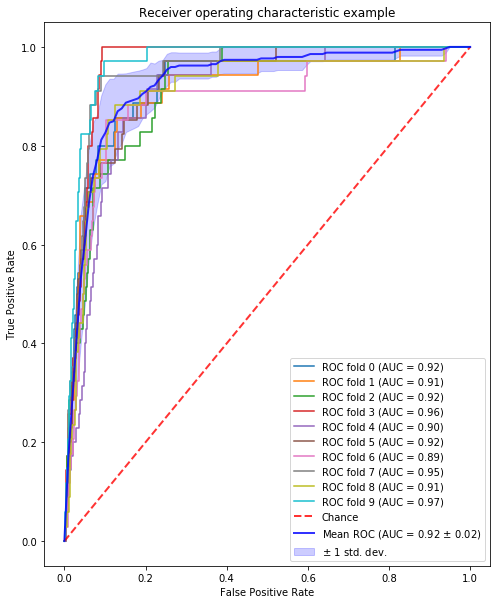

Confusion matrix, without normalization
[[289729    308]
 [   345      0]]


<Figure size 432x288 with 0 Axes>

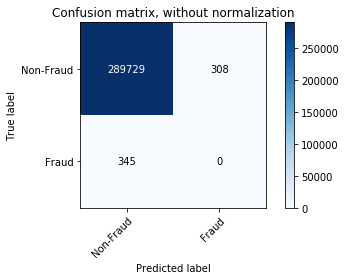

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA(solver='svd')
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


28936 68 11 24
28910 94 1 34


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


28717 287 1 34
28961 43 6 29


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


28897 107 8 27
28815 189 20 14


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


28890 114 4 30
28782 221 12 22


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


28897 106 2 32
28623 380 2 32


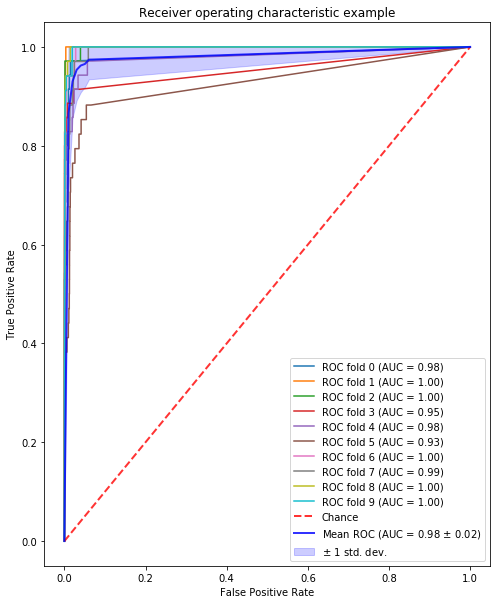

Confusion matrix, without normalization
[[288428   1609]
 [    67    278]]


<Figure size 432x288 with 0 Axes>

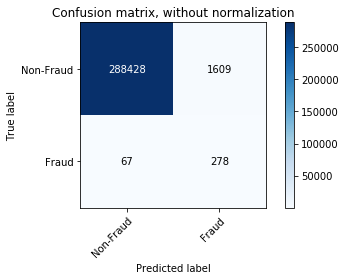

In [13]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

clf = QDA()
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = KNN(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', n_jobs=-1)
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

29003 1 1 34
29004 0 0 35
29004 0 0 35
29004 0 0 35
29004 0 0 35
29004 0 1 33
29004 0 0 34
29003 0 1 33
29003 0 0 34
29003 0 1 33


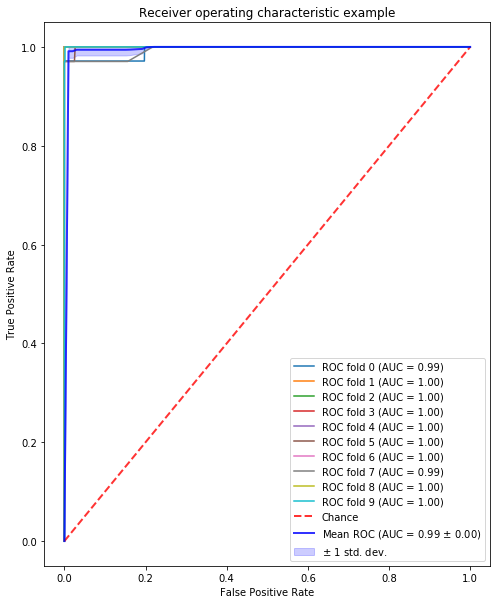

Confusion matrix, without normalization
[[290036      1]
 [     4    341]]


<Figure size 432x288 with 0 Axes>

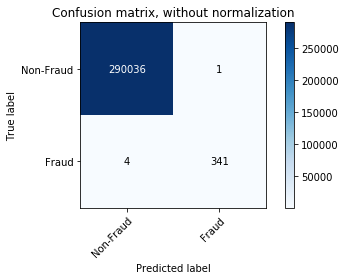

In [14]:
from sklearn.ensemble import AdaBoostClassifier as AdaBoost

clf = AdaBoost(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R')
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

### Dimensionality Reduction & Scaling

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as StandardScaler

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

pca = PCA(n_components=0.95, whiten = True)
X_pca = pca.fit_transform(X_scaled)
pca.n_components_

7

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1247 27757 0 35
29004 0 0 35
17593 11411 0 35
29004 0 0 35
29004 0 16 19
29004 0 0 34
29004 0 0 34
29003 0 15 19
29002 1 29 5
29003 0 32 2


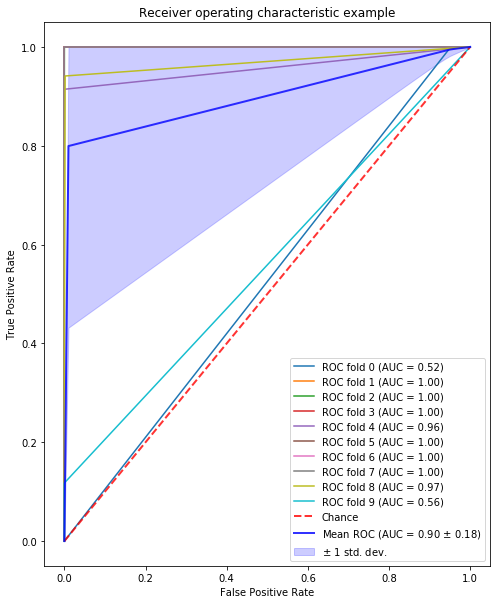

Confusion matrix, without normalization
[[250868  39169]
 [    92    253]]


<Figure size 432x288 with 0 Axes>

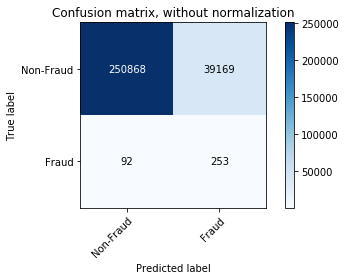

In [13]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)